In [ ]:
from google.colab import files

files.upload() 


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d adityajn105/flickr8k
!unzip -q flickr8k.zip


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 98% 1.01G/1.04G [00:07<00:00, 161MB/s]
100% 1.04G/1.04G [00:07<00:00, 143MB/s]


In [4]:
import os
import pickle
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [5]:
DATA_DIR = "/content"
IMAGE_DIR = os.path.join(DATA_DIR, "Images")
WORK_DIR = "/content/working"

os.makedirs(WORK_DIR, exist_ok=True)


In [6]:
vgg = VGG16(weights="imagenet")
vgg = Model(inputs=vgg.inputs, outputs=vgg.layers[-2].output)
vgg.summary()


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
features = {}

for img_name in tqdm(os.listdir(IMAGE_DIR)):
    img_path = os.path.join(IMAGE_DIR, img_name)

    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    feature = vgg.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature


100%|██████████| 8091/8091 [11:41<00:00, 11.53it/s]


In [8]:
with open(os.path.join(WORK_DIR, "features.pkl"), "wb") as f:
    pickle.dump(features, f)

with open(os.path.join(WORK_DIR, "features.pkl"), "rb") as f:
    features = pickle.load(f)


In [9]:
with open(os.path.join(DATA_DIR, "captions.txt")) as f:
    next(f)
    captions_doc = f.read()


In [10]:
mapping = {}

for line in captions_doc.split("\n"):
    tokens = line.split(",")
    if len(tokens) < 2:
        continue

    image_id = tokens[0].split(".")[0]
    caption = " ".join(tokens[1:])

    mapping.setdefault(image_id, []).append(caption)

len(mapping)


8091

In [11]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r"[^a-z ]", "", caption)
            caption = re.sub(r"\s+", " ", caption)
            caption = "start " + " ".join(
                [w for w in caption.split() if len(w) > 1]
            ) + " end"
            captions[i] = caption

clean(mapping)


In [12]:
all_captions = [c for caps in mapping.values() for c in caps]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in all_captions)

vocab_size, max_length


(8766, 34)

In [13]:
image_ids = list(mapping.keys())
split = int(0.9 * len(image_ids))

train = image_ids[:split]
test = image_ids[split:]


In [ ]:
def data_generator(keys, mapping, features, tokenizer, max_length, batch_size):
    X1, X2, y = [], [], []

    while True:
        for key in keys:
            for caption in mapping[key]:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq = pad_sequences(
                        [seq[:i]], maxlen=max_length
                    )[0]

                    out_seq = seq[i]  
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

                    if len(X1) == batch_size:
                        yield (
                            (np.array(X1), np.array(X2)),  
                            np.array(y)
                        )
                        X1, X2, y = [], [], []


In [31]:
# Image encoder
inputs1 = Input(shape=(4096,))
x1 = Dropout(0.4)(inputs1)
x1 = Dense(256, activation="relu")(x1)

# Caption encoder
inputs2 = Input(shape=(max_length,))
x2 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
x2 = Dropout(0.4)(x2)
x2 = LSTM(256, use_cudnn=False)(x2)

# Decoder
decoder = add([x1, x2])
decoder = Dense(256, activation="relu")(decoder)
outputs = Dense(vocab_size, activation="softmax")(decoder)

model = Model([inputs1, inputs2], outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 34, 256)   │  2,244,096 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 4096)      │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 34, 256)   │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 34)        │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    525,312 │ dropout_7[0][0],  │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256)       │          0 │ dense_9[0][0],    │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     65,792 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 8766)      │  2,252,862 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,136,894 (23.41 MB)

 Trainable params: 6,136,894 (23.41 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
epochs = 20
batch_size = 16
steps = (len(train) * 8) // batch_size

generator = data_generator(
    train, mapping, features,
    tokenizer, max_length, batch_size
)

model.fit(
    generator,
    epochs=epochs,
    steps_per_epoch=steps,
    verbose=1
)



Epoch 1/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - loss: 5.9015
Epoch 2/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 4.9640
Epoch 3/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 4.6568
Epoch 4/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 4.6994
Epoch 5/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 4.5503
Epoch 6/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 4.4411
Epoch 7/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 4.3221
Epoch 8/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 4.2101
Epoch 9/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.9863
Epoch 10/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 4.0040
Epoch 11/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 4.0087
Epoch 12/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.9101
Epoch 13/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 4.0258
Epoch 14/20
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.9272
E

In [33]:
model.fit(
    generator,
    epochs=35,          # final epoch number
    initial_epoch=20,   # start from epoch 20 (i.e., epoch 21)
    steps_per_epoch=steps,
    verbose=1
)

Epoch 21/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.7215
Epoch 22/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.6418
Epoch 23/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.7151
Epoch 24/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.7543
Epoch 25/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.7196
Epoch 26/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.7156
Epoch 27/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.6950
Epoch 28/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.5622
Epoch 29/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.6095
Epoch 30/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.7079
Epoch 31/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.5873
Epoch 32/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.6743
Epoch 33/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 3.6159
Epoch 34/35
3640/3640 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss:

In [34]:
def idx_to_word(idx, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == idx:
            return word
    return None


In [35]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = "start"

    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], max_length)
        yhat = model.predict([image, seq], verbose=0)
        yhat = np.argmax(yhat)

        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break

        in_text += " " + word
        if word == "end":
            break

    return in_text


In [36]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = [], []

for key in tqdm(test):
    y_pred = predict_caption(model, features[key], tokenizer, max_length).split()
    actual.append([c.split() for c in mapping[key]])
    predicted.append(y_pred)

print("BLEU-1:", corpus_bleu(actual, predicted, weights=(1,0,0,0)))
print("BLEU-2:", corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))


100%|██████████| 810/810 [10:08<00:00,  1.33it/s]


BLEU-1: 0.5252637423653526
BLEU-2: 0.27361232357087156


start two dogs are running on the grass end


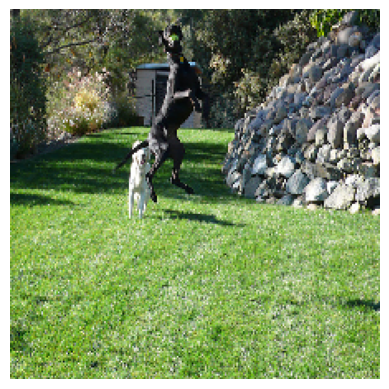

In [49]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/content/Images/1679565118_d36f0d6d52.jpg"

image = load_img(img_path, target_size=(224,224))
img = img_to_array(image)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

feature = vgg.predict(img, verbose=0)

caption = predict_caption(model, feature, tokenizer, max_length)

plt.imshow(image)
plt.axis("off")
print(caption)


In [ ]:
import pickle
import json


with open(os.path.join(WORK_DIR, "tokenizer.pkl"), "wb") as f:
    pickle.dump(tokenizer, f)


with open(os.path.join(WORK_DIR, "max_length.txt"), "w") as f:
    f.write(str(max_length))


with open(os.path.join(WORK_DIR, "vocab_size.txt"), "w") as f:
    f.write(str(vocab_size))

model.save(os.path.join(WORK_DIR, "caption_model.keras"))

In [51]:
from google.colab import files

files.download(os.path.join(WORK_DIR, "caption_model.keras"))
files.download(os.path.join(WORK_DIR, "tokenizer.pkl"))
files.download(os.path.join(WORK_DIR, "max_length.txt"))
files.download(os.path.join(WORK_DIR, "vocab_size.txt"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>